# Reconstruction problem notebook

In [3]:
import numpy as np
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size):
        super(ThisModel, self).__init__()

        # Encoder
        self.size = size


        self.linear_block = nn.Sequential(
            nn.SELU(),
            nn.Linear(size * size, 1),
            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x):
        bs = x.size()[0]

        x = self.linear_block(x.view(bs, self.size * self.size))


       

        return x
    
def test():
    device = torch.device("cuda:0")
    model = ThisModel(80).to(device).eval()
    x = torch.randn(1, 1, 80, 80, device=device)
    print(model(x).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

torch.Size([1, 1])
params 6401


In [ ]:
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size):
        super(ThisModel, self).__init__()

        # Encoder
        self.size = size


        self.linear_block = nn.Sequential(
            nn.Linear(size * size + 1, size * size),
            nn.Sigmoid(),
            nn.Linear(size * size, size * size - 600),
            nn.Sigmoid(),
            nn.Linear(size * size - 600, size * size),
            nn.Sigmoid(),
            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x, k0):
        bs = x.size()[0]
        x = torch.cat((x.view(self.size * self.size, bs), k0.view(1, bs))).view(bs, self.size * self.size + 1)
        x = self.linear_block(x).view(bs, 1, self.size, self.size)


       

        return x
    
def test():
    device = torch.device("cpu:0")
    model = ThisModel(80).to(device).eval()
    x = torch.randn(1, 1, 80, 80, device=device)
    k0 = torch.randn(1, 1, 1, 1, device=device)
    print(model(x, k0).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

In [ ]:
import torch
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size):
        super(ThisModel, self).__init__()

        # Encoder
        self.size = size


        self.linear_block = nn.Sequential(
            nn.Linear(2 * size ** 2, size * size),
            nn.SELU(),
            nn.Linear(size * size, size * size - 600),
            nn.Sigmoid(),
            nn.Linear(size * size - 600, size * size),
            nn.Sigmoid(),
            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x1, x2):
        bs = x1.size()[0]
        inp_size = int(2 * self.size ** 2 + 1)
        x = torch.cat((x1.view(self.size * self.size, bs), x2.view(self.size * self.size, bs))).view(bs, 2 * self.size ** 2)
        x = self.linear_block(x).view(bs, 1, self.size, self.size)


       

        return x
    
def test():
    device = torch.device("cpu:0")
    model = ThisModel(80).to(device).eval()
    x1 = torch.randn(1, 1, 80, 80, device=device)
    x2 = torch.randn(1, 1, 80, 80, device=device)
    print(model(x1, x2).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

In [ ]:
import torch
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size: int):
        super(ThisModel, self).__init__()

        # Encoder
        self.size: int = size


        self.linear_block = nn.Sequential(
            nn.Linear(2 * size ** 2 + 1, size * size),
            nn.SELU(),
            nn.Linear(size * size, size * size - 600),
            nn.SELU(),
            nn.Linear(size * size - 600, size * size),
            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x1, x2, k0):
        bs = x1.size()[0]
        inp_size = int(2 * self.size ** 2 + 1)
        x = torch.cat((x1.view(self.size * self.size, bs), x2.view(self.size * self.size, bs))).view(bs, inp_size - 1)
        x = torch.cat((x.view(inp_size - 1, bs), k0.view(1, bs))).view(bs, inp_size)
        x = self.linear_block(x).view(bs, 1, self.size, self.size)


       

        return x
    
def test():
    device = torch.device("cpu:0")
    model = ThisModel(80).to(device).eval()
    x1 = torch.randn(1, 1, 80, 80, device=device)
    x2 = torch.randn(1, 1, 80, 80, device=device)
    k0 = torch.randn(1, 1, 1, 1, device=device)
    print(model(x1, x2, k0).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

In [ ]:
import torch
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size: int):
        super(ThisModel, self).__init__()

        # Encoder
        self.size: int = size


        self.linear_block = nn.Sequential(
            nn.Linear(2 * size ** 2 + 1, size * size),
            nn.Sigmoid(),
            nn.Linear(size * size, size * size - 600),
            nn.Sigmoid(),
            nn.Linear(size * size - 600, size * size),
            nn.Sigmoid(),
            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x1, x2, k0):
        bs = x1.size()[0]
        inp_size = int(2 * self.size ** 2 + 1)
        x = torch.cat((x1.view(self.size * self.size, bs), x2.view(self.size * self.size, bs))).view(bs, inp_size - 1)
        x = torch.cat((x.view(inp_size - 1, bs), k0.view(1, bs))).view(bs, inp_size)
        x = self.linear_block(x).view(bs, 1, self.size, self.size)


       

        return x
    
def test():
    device = torch.device("cpu:0")
    model = ThisModel(80).to(device).eval()
    x1 = torch.randn(1, 1, 80, 80, device=device)
    x2 = torch.randn(1, 1, 80, 80, device=device)
    k0 = torch.randn(1, 1, 1, 1, device=device)
    print(model(x1, x2, k0).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

In [ ]:
import torch
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size):
        super(ThisModel, self).__init__()

        # Encoder
        self.size = size


        self.linear_block = nn.Sequential(
            nn.Linear(2 * size ** 2, size * size),
            nn.ReLU(),
            nn.Linear(size * size, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1),
            nn.ReLU(),

            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x1, x2):
        bs = x1.size()[0]
        inp_size = int(2 * self.size ** 2)
        x = torch.cat((x1.view(self.size * self.size, bs), x2.view(self.size * self.size, bs))).view(bs, inp_size)
        x = self.linear_block(x)


       

        return x
    
def test():
    device = torch.device("cpu:0")
    model = ThisModel(80).to(device).eval()
    x1 = torch.randn(1, 1, 80, 80, device=device)
    x2 = torch.randn(1, 1, 80, 80, device=device)
    print(model(x1, x2).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

=================================================================================================================

## Библиотеки, параметры, константы задачи

In [2]:
from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
from common.fstream import read_tensor, read_matrix, rescale_array, read_mc_tensor

PATH_BASE = "/home/amedvedev/projects/python/DenoisingCNN"
NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="model_31", name_dataset=NAME_DATASET, path_base=PATH_BASE,
                      device_name="cuda")


## Загрузка данных

### Восстанавление $\left|k\right|$ по $\left|y_{выч}\right|$, разделённому на левую ($\left|y_{выч}\right|_{L}$) и правую ($\left|y_{выч}\right|_{R}$) части

In [ ]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=40, height=80, feature_name="Uvych_abs_left.xls", mapper=read_matrix
    ) \
    .load_feature(
        width=40, height=80, feature_name="Uvych_abs_right.xls", mapper=read_matrix
    ) \
    .set_target(
        width=80, height=80, target_name="K_abs.xls", mapper=read_tensor
    ) \
    

print(env.train_count, env.val_count)


### Восстанавление $\left|k\right|$ из $\tilde{\left|k\right|}$ (noised)

In [ ]:
mapper_div = lambda path: read_matrix(path, coeff_norm=61.) # 140

env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="K_noised_abs.xls", mapper=mapper_div, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="K_abs.xls", mapper=mapper_div, transform=None
    ) \
    
print(env.train_count, env.val_count)

In [2]:

env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        shape=(64, 80, 80), feature_name="K_abs_noised.tensor", mapper=lambda path: read_mc_tensor(path, rescale_each=(0., 1.)), transform=None, 
        lazy_load=False, pct_load=0.8
    ) \
    .set_target(
        shape=(1, 80, 80), target_name="K_abs.xls", mapper=lambda path: read_tensor(path), transform=None, 
        lazy_load=False, pct_load=0.8
    ) \
    
# print(env.train_count, env.val_count)

In [3]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        shape=(64, 80, 80), 
        feature_name="K_abs_noised.tensor", 
        mapper=lambda path: read_mc_tensor(path) / 30., 
        transform=None, 
        lazy_load=False, 
        pct_load=1
    ) \
    .set_target(
        shape=(1, 80, 80), 
        target_name="K_abs.xls", 
        mapper=lambda path: read_matrix(path, 10.), 
        transform=None, 
        lazy_load=False, pct_load=1
    ) \
    
# print(env.train_count, env.val_count)

In [9]:
env.train_features_loaders[0][9][0][0]

tensor([[1.2053, 1.1735, 1.1888,  ..., 1.1851, 1.1969, 1.1543],
        [1.2013, 1.1969, 1.1872,  ..., 1.1577, 1.2064, 1.1649],
        [1.2061, 1.1557, 1.2034,  ..., 1.1678, 1.1995, 1.1707],
        ...,
        [1.1687, 1.1791, 1.1614,  ..., 1.1542, 1.1849, 1.2049],
        [1.1593, 1.1643, 1.1699,  ..., 1.2059, 1.1565, 1.1860],
        [1.1794, 1.1758, 1.1679,  ..., 1.1739, 1.1758, 1.1971]],
       device='cuda:0')

In [ ]:
import numpy as np
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=4
    ) \
    .load_feature(
        shape=(64, 80, 80), feature_name="Uvych2_abs_noised.tensor", mapper=lambda path: np.interp(read_mc_tensor(path), (-5, 6), (0, 1)), transform=None
    ) \
    .set_target(
        shape=(1, 80, 80), target_name="Uvych2_abs.xls", mapper=lambda path: np.interp(read_matrix(path), (-5, 6), (0, 1)), transform=None
    ) \
    
print(env.train_count, env.val_count)

### Восстанавление $\left|k-k_{0}\right|$ из $\left|k-k_{0}\right|$ (noised)

In [ ]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=4, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="K-k0_noised_abs.xls", mapper=read_tensor, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="K-k0_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

### Восстанавление $\left|k\right|$ из $\left|y_{выч}\right|$ 

In [ ]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_abs.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="K_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)


### Восстанавление $\left|W\right|$ из $\left|y_{выч}\right|$ & $K_{0}$ 


In [ ]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_abs.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=1, height=1, feature_name="k0_re.txt", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="W_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

### Восстанавление $\left|W\right|$ по комплексному $y_{выч}$

In [ ]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_re.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_im.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=1, height=1, feature_name="k0_re.txt", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="W_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

### Восстанавление $Re\left[k_{0}\right]$ по комплексному $y_{выч}$ 

In [ ]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_re.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_im.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=1, height=1, target_name="k0_re.txt", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

### Восстанавление $\left|K\right|$ по комплексному $y_{выч}$ и $Re\left[k_{0}\right]$

In [ ]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_re.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_im.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=1, height=1, feature_name="k0_re.txt", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="K_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

### Восстанавление $Re\left[k_{0}\right]$ из $\left|y_{выч}\right|$ 

In [ ]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_abs.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=1, height=1, target_name="k0_re.txt", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)


### Восстанавление $\left|y_{выч}\right|$ из $\left|k\right|$ 

In [ ]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=8, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="K_abs.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="Uvych2_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

### Восстанавление $\left|y_{выч}\right|_{L}$ из $\left|\tilde{y}_{выч}\right|_{L}$ (noised)


In [ ]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=4, val_batch_size=4
    ) \
    .load_feature(
        width=40, height=80, feature_name="Uvych_noised_abs_left.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=40, height=80, target_name="Uvych_abs_left.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

===================================================================================================================================

## Модели

### VQGAN

In [ ]:
env.model = models.vqgan.VQGAN_mod(type('', (object, ), 
    {'image_channels': 1, 'latent_dim': 256, 'device': env.device_name, 
     'num_codebook_vectors': 1024, 'beta': 0.25})()).to(env.device)

### U-net

In [3]:
env.model = models.UnetAutoencoder.UNetAuto(num_channels=64, num_out_channels=1, max_features=256).to(env.device)

### Hybrid Perception Block 

In [ ]:
from ITTR_pytorch import HPB
env.model = HPB(
    dim = 1,              # dimension
    dim_head = 80,          # dimension per attention head
    heads = 8,              # number of attention heads
    attn_height_top_k = 16, # number of top indices to select along height, for the attention pruning
    attn_width_top_k = 16,  # number of top indices to select along width, for the attention pruning
    attn_dropout = 0.,      # attn dropout
    ff_mult = 4,            # expansion factor of feedforward
    ff_dropout = 0.         # feedforward dropout
).to(env.device)

### Dual-Pruned Self-Attention (DPSA) block

In [ ]:
from ITTR_pytorch import DPSA


env.model = DPSA(
    dim = 1,         # dimension
    dim_head = 80,     # dimension per attention head
    heads = 8,         # number of attention heads
    height_top_k = 48, # number of top indices to select along height, for the attention pruning
    width_top_k = 48,  # number of top indices to select along width, for the attention pruning
    dropout = 0.       # attn dropout
).to(env.device)

### Новая локальная модель

In [ ]:
env.init_model(models.autoencoders.ConvAutoencoderLuma5)

In [ ]:
env.model = ThisModel(80).to(env.device)

In [10]:
env.model = models.autoencoders.ConvAutoencoderLumaRelu(in_channels=64, out_channels=1).to(env.device)

### Импорт претренерованной модели

In [ ]:
env.load_model(model_type="pt")

===================================================================================================================================

## Визуализация батча валидационного датасета

/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


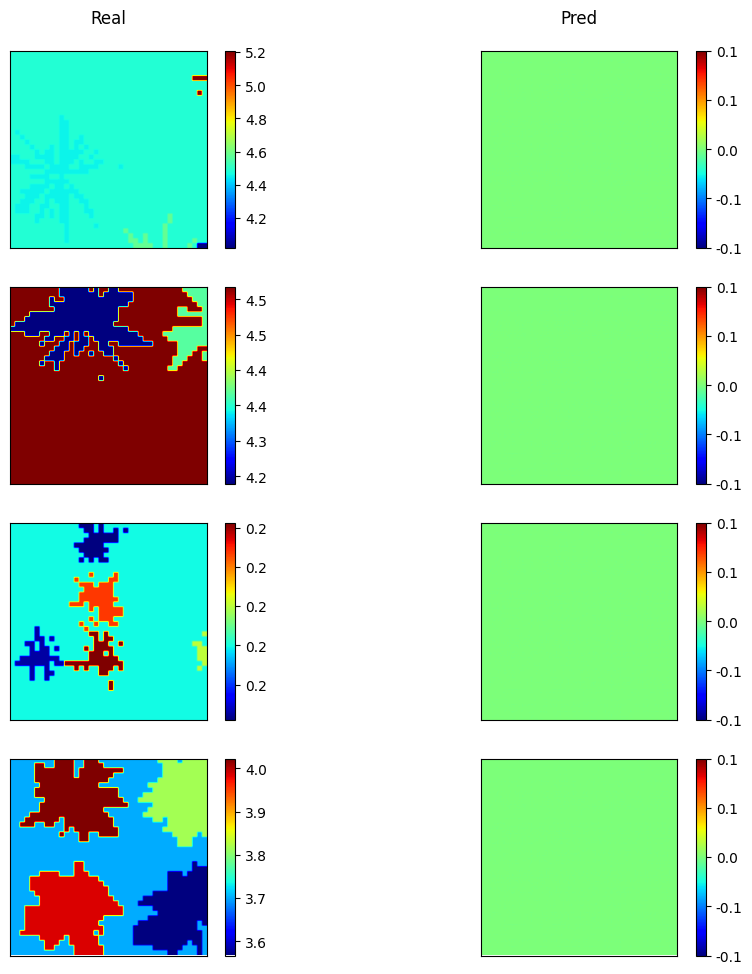

In [11]:
env.plot_batch(concrete=5, figsize=(10, 10), format="%.1f", wspace=0.0, hspace=0.2)


In [ ]:
env.plot_batch_with_inputs(concrete=1, figsize=(10, 10), format="%.1f", wspace=0.0, hspace=0.2)

===================================================================================================================================

## Численные значения отклонений

In [22]:
def test():
    losses = []
    errors = []
    init_errors = []
    losses_dataset = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features) #* 65.
            losses_dataset_step = min([torch.max(torch.abs(data_features[0][i] - data_target)).detach().tolist()
                                       for i in range(len(data_features))])
            losses_dataset.append(losses_dataset_step)
            loss = torch.max(torch.abs(outputs - data_target))
            init_error = torch.mean(torch.abs(data_features[0] - data_target) / data_target)
            error = torch.mean(torch.abs(outputs - data_target) / data_target)
            losses.append(loss.detach().tolist())
            errors.append(error.detach().tolist())
            init_errors.append(init_error.detach().tolist())
            #print(outputs, data_target)
    print(losses_dataset)
    print("Среднее отклонение по значениям в векторе:", sum(losses) / len(losses))
    print("Максимальное отклонение по значениям в векторе:", max(losses))
    print()
    print("Начальное среднее отклонение по значениям в векторе:", max(losses_dataset))
    print()
    print("Dataset Средняя относительная ошибка:", sum(init_errors) / len(init_errors))
    print("Dataset Максимальная относительная ошибка:", max(init_errors))
    print()
    print("Средняя относительная ошибка:", sum(errors) / len(errors))
    print("Максимальная относительная ошибка:", max(errors))
test()

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9696030616760254, 1.0, 1.0, 0.9676789045333862, 0.9530405402183533]
Среднее отклонение по значениям в векторе: 0.6760779710916373
Максимальное отклонение по значениям в векторе: 0.7639027833938599

Начальное среднее отклонение по значениям в векторе: 1.0

Dataset Средняя относительная ошибка: nan
Dataset Максимальная относительная ошибка: nan

Средняя относительная ошибка: nan
Максимальная относительная ошибка: nan


===================================================================================================================================

## Training

In [9]:
from common.losses import MseCoeffLoss, L1CoeffLoss

In [ ]:
# optimizer = torch.optim.Adam(env.model.parameters(), lr=0.00001)
# #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.65 ** epoch)
# 
# env.train(3, step_saving=False, step_plotting=False,
#           optimizer=optimizer, scheduler=None, 
#           criterion=MyLoss(reduce="none", reduction="none", coeff=10000000.0))

In [13]:
env.train(10, step_saving=False, step_plotting=False,
          optimizer=torch.optim.Adam(env.model.parameters(), lr=0.01), scheduler=None, 
          criterion=torch.nn.BCELoss(reduction="none", reduce="none"))

/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 3.032132 	Validating Loss: 0.695596 	Time: 0.42 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.691567 	Validating Loss: 0.697662 	Time: 0.42 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.691231 	Validating Loss: 0.697039 	Time: 0.42 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.6

In [10]:
env.train(30, step_saving=False, step_plotting=False,
          optimizer=torch.optim.Adam(env.model.parameters(), lr=0.001), scheduler=None, 
          criterion=MseCoeffLoss(reduce="none", reduction="none", coeff=1.0))

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.006565 	Validating Loss: 0.029685 	Time: 0.10 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.004888 	Validating Loss: 0.029345 	Time: 0.10 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.003504 	Validating Loss: 0.029815 	Time: 0.10 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.

№1

In [8]:
optimizer = torch.optim.Adam(env.model.parameters(), lr=0.0001)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.65 ** epoch)

env.train(5, step_saving=True, step_plotting=False,
          optimizer=optimizer, scheduler=None, 
          criterion=MseCoeffLoss(reduce="none", reduction="none", coeff=1.0))

NameError: name 'MseCoeffLoss' is not defined

In [ ]:
def warmup(current_step: int):
    if current_step < args.warmup_steps:  # current_step / warmup_steps * base_lr
        return float(current_step / args.warmup_steps)
    else:                                 # (num_training_steps - current_step) / (num_training_steps - warmup_steps) * base_lr
        return max(0.0, float(args.training_steps - current_step) / float(max(1, args.training_steps - args.warmup_steps)))

In [17]:
env.train(6 , step_saving=False, step_plotting=False,
          optimizer=torch.optim.Adam(env.model.parameters(), lr=0.001), scheduler=None, 
          criterion=torch.nn.L1Loss())


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.140547 	Validating Loss: 0.078234 	Time: 0.14 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.082014 	Validating Loss: 0.092198 	Time: 0.14 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.068777 	Validating Loss: 0.068129 	Time: 0.14 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.0

## Сохранение модели

In [16]:
env.save(onnx=False, pth=False)

## Loss visualisation

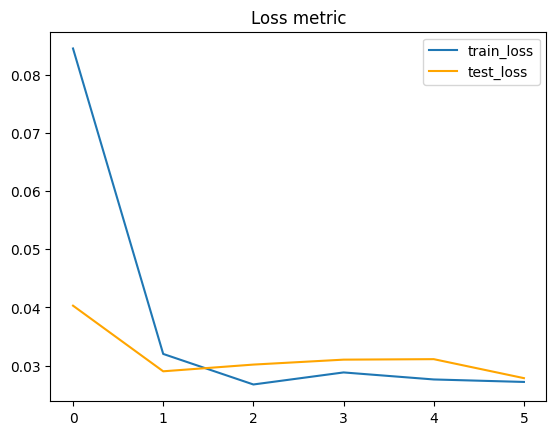

In [15]:
env.show_metrics(n_last=50, train=True, val=True)

## Clear memory

In [18]:
import gc
gc.collect()


5809

In [15]:
env.model.cpu()
del env.model

torch.cuda.empty_cache()

In [16]:
torch.cuda.empty_cache()